# Inferring diffusion operators - more complicated example

In this example, we will consider the diffusion equation with Dirichlet and
Neumann homogeneous boundary conditions, a variable diffusivity $\kappa(x)$,
and a variable source term $s(x)$. You may change the profiles of $\kappa$
and $s$.

## The Julia bootstrap block (for Google Colab)
Source: https://colab.research.google.com/drive/1_4Yz3FKO5_uuYvamEfHqwtFT9WpCuSbm

This should be run for the first time to install Julia kernel, and then refresh this page (e.g., Ctrl-R)
so that colab will redirect to the installed Julia kernel
and then doing your own work

In [ ]:
# 1. install latest Julia using jill.py
#    tip: one can install specific Julia version using e.g., `jill install 1.7`
!pip install jill && jill install --upstream Official --confirm

# 2. install IJulia kernel
! julia -e 'using Pkg; pkg"add IJulia"; using IJulia; installkernel("Julia")'

# 3. hot-fix patch to strip the version suffix of the installed kernel so
# that this notebook kernelspec is version agnostic
#!jupyter kernelspec install $(jupyter kernelspec list | grep julia | tr -s ' ' | cut -d' ' -f3) --replace --name julia

In [ ]:
using Pkg; Pkg.add(["OrdinaryDiffEq", "DiffEqFlux", "Plots"])

We start by loading some packages.

In [1]:
using LinearAlgebra
using SparseArrays
using OrdinaryDiffEq
using DiffEqFlux
using Plots

┌ Info: Precompiling OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed]
└ @ Base loading.jl:1423
┌ Info: Precompiling DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0]
└ @ Base loading.jl:1423
  ** incremental compilation may be fatally broken for this module **

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


Since the problems will consist of inferring various matrices, we define a small helper
function for visualizing our results.

In [2]:
plotmat(A; kwargs...) = heatmap(
    reverse(A; dims = 1);
    aspect_ratio = :equal,
    xlims = (1 / 2, size(A, 2) + 1 / 2),
    ylims = (1 / 2, size(A, 1) + 1 / 2),
    # xticks = nothing,
    # yticks = nothing,
    kwargs...,
)
plotmat(A::AbstractSparseMatrix; kwargs...) = plotmat(Matrix(A); kwargs...)

plotmat (generic function with 2 methods)

## Problem statement

This time, we consider a linear ordinary differential equation (ODE)
parameterized by an operator $\mathbf{A} \in \mathbb{R}^{(N + 1) \times (N +
1)}$ *and* a constant source term $\mathbf{s} \in \mathbb{R}^{N + 1}$:

$$\frac{\mathrm{d} \mathbf{u}}{\mathrm{d} t} = \mathbf{f}(\mathbf{u},
\mathbf{\theta}, t) := \mathbf{A} \mathbf{u} + \mathbf{s}, \quad
\mathbf{u}(0) = \mathbf{u}_0$$

where $\mathbf{u}_0 \in \mathbb{R}^{N + 1}$ are some initial conditions and
$\mathbf{\theta} = \begin{pmatrix} \mathbf{A} & \mathbf{s} \end{pmatrix} \in
\mathbb{R}^{(N + 1) \times (N + 2)}$. To solve this system, we will use the
[OrdinaryDiffEq](https://github.com/SciML/OrdinaryDiffEq.jl) package. It
provides differentiable ODE solvers for problems defined by a parametrized
ODE function $f$ defining the right hand side of the ODE for a given state
$\mathbf{u}$, time $t$ and parameters $\mathbf{\theta}$.

In [3]:
function f(u, θ, t)
    A = @view θ[:, 1:end-1]
    s = @view θ[:, end]
    A * u .+ s
end
function f!(du, u, θ, t)
    A = @view θ[:, 1:end-1]
    s = @view θ[:, end]
    mul!(du, A, u)
    du .+= s
end

f! (generic function with 1 method)

Let us define the ODE solver (the in-place form `S!` may be faster for
generating large datasets, but is not as easily differentiable):

In [4]:
function S(θ, u₀, t; kwargs...)
    problem = ODEProblem(ODEFunction(f), u₀, extrema(t), θ)
    solve(problem, Tsit5(); saveat = t, kwargs...)
end
function S!(θ, u₀, t; kwargs...)
    problem = ODEProblem(ODEFunction(f!), u₀, extrema(t), θ)
    solve(problem, Tsit5(); saveat = t, kwargs...)
end

S! (generic function with 1 method)

Consider now the diffusion equation

$$\frac{\partial u}{\partial t}(x, t) = \kappa(x) \frac{\partial^2 u}{\partial x^2}(x, t) + s(x), \quad x \in
\Omega = [0, 1]$$

with diffusivity $\kappa > 0$, source term $s$, and left homogeneous Dirichlet boundary conditions $u(0, t) = 0$, right homogeneous Neumann boundary conditions $\frac{\partial u}{\partial x}(1, t) = 0$, and initial conditions $u(x, 0) = u_0(x)$. *You may change the expressions for $\kappa$ and $s$*.

In [5]:
κ(x) = x ≤ 1 / 2 ? 0.01 : 0.001
source(x) = 1 / 5 * sin(2π * x) * (x ≤ 1 / 2)

source (generic function with 1 method)

The domain $\Omega$ may be discretized using a uniform grid $\mathbf{x} = (x_n)_{0 \leq n
\leq N}$ of $N + 1$ equidistant points.

In [6]:
N = 50
x = LinRange(0.0, 1.0, N + 1)
Δx = 1 / N

0.02

On the above grid, the diffusion operator $\frac{\partial^2}{\partial x^2}$ with left
Dirichlet and right Neumann boundary conditions may be approximated using the matrix

$$\mathbf{D} = \frac{1}{\Delta x^2} \begin{pmatrix}
    0 &  \dots &  \dots &  \dots & 0 \\
    1 &     -2 &      1 &        &   \\
      & \ddots & \ddots & \ddots &   \\
      &        &      1 &     -2 & 1 \\
      &        &      1 &     -2 & 1 \\
\end{pmatrix}.$$

A second order accurate diffusion stencil is given by

In [9]:
inds = [-1, 0, 1]
stencil = [1, -2, 1] / Δx^2

3-element Vector{Float64}:
  2500
 -5000
  2500

Alternatively, a fourth order accurate diffusion stencil may be used. For higher order stencils, see
https://en.wikipedia.org/wiki/Finite_difference_coefficient

In [8]:
inds = -2:2
stencil = [-1 / 12, 4 / 3, -5 / 2, 4 / 3, -1 / 12] / Δx^2

5-element Vector{Float64}:
  -208.3
  3333
 -6250
  3333
  -208.3

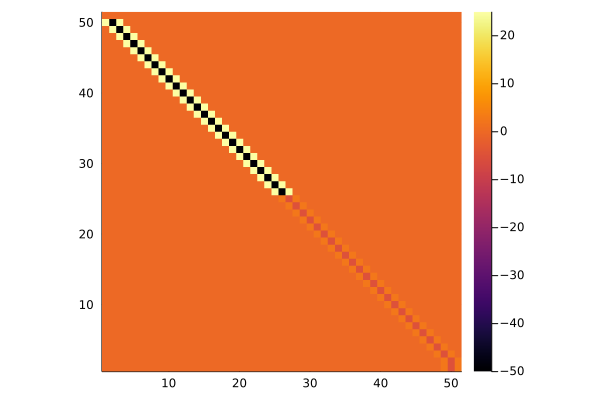

In [10]:
A_ref =
    diagm(κ.(x)) * diagm((i => fill(s, N + 1 - abs(i)) for (i, s) ∈ zip(inds, stencil))...)
A_ref[1, :] .= 0 # Left Dirichlet boundary conditions
A_ref[end, :] .= A_ref[end-1, :] # Right Neumann boundary conditions (first order)
# @. A_ref[end, :] = 2 / 3 * (2 * A_ref[end - 1, :] - 1 / 2 * A_ref[end - 2, :]) # Right Neumann boundary conditions (second order)
plotmat(A_ref)

Discrete source term with boundary conditions

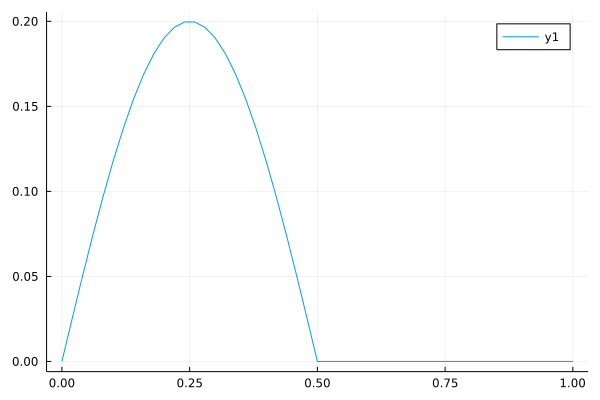

In [11]:
s_ref = source.(x)
s_ref[1] = 0
s_ref[end] = s_ref[end-1]
plot(x, s_ref)

Reference parameters

In [12]:
θ_ref = [A_ref s_ref]

51×52 Matrix{Float64}:
  0    0    0    0    0    0    0    0  …   0     0     0    0     0
 25  -50   25    0    0    0    0    0      0     0     0    0     0.02507
  0   25  -50   25    0    0    0    0      0     0     0    0     0.04974
  0    0   25  -50   25    0    0    0      0     0     0    0     0.07362
  0    0    0   25  -50   25    0    0      0     0     0    0     0.09635
  0    0    0    0   25  -50   25    0  …   0     0     0    0     0.1176
  0    0    0    0    0   25  -50   25      0     0     0    0     0.1369
  0    0    0    0    0    0   25  -50      0     0     0    0     0.1541
  0    0    0    0    0    0    0   25      0     0     0    0     0.1689
  0    0    0    0    0    0    0    0      0     0     0    0     0.181
  0    0    0    0    0    0    0    0  …   0     0     0    0     0.1902
  0    0    0    0    0    0    0    0      0     0     0    0     0.1965
  0    0    0    0    0    0    0    0      0     0     0    0     0.1996
  ⋮              

In [13]:
function create_data(u₀, x, t, θ)
    A = θ[:, 1:end-1]
    s = θ[:, end]
    u = S!(θ, u₀, t; abstol = 1e-8, reltol = 1e-10)
    dudt = zeros(size(u))
    for i = 1:length(t)
        dudt[:, :, i] = A * u[i] .+ s
    end
    (; u, dudt)
end

create_data (generic function with 1 method)

In [14]:
function apply_bc!(u)
    u[1] = 0
    u[end] = u[end-1]
    u
end

apply_bc! (generic function with 1 method)

Four particular solutions are given below. We may use this solution to test
our solver, from now on referred to as the *full order model* (FOM).

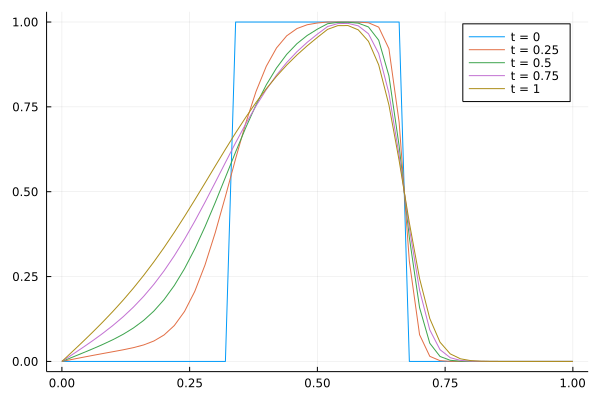

In [16]:
u₁ = apply_bc!(@. sin(4π * x))
u₂ = apply_bc!(@. exp(-x) * x)
u₃ = apply_bc!(@. 1 / 3 ≤ x ≤ 2 / 3)
u₄ = apply_bc!(zeros(size(x)))
tplot = LinRange(0.0, 1.0, 5)
## u, dudt = create_data(reshape(u₁, :, 1), x, tplot, θ_ref)
## u, dudt = create_data(reshape(u₂, :, 1), x, tplot, θ_ref)
u, dudt = create_data(reshape(u₃, :, 1), x, tplot, θ_ref)
## u, dudt = create_data(reshape(u₄, :, 1), x, tplot, θ_ref)
pl = plot();
for (i, t) ∈ enumerate(tplot)
    plot!(pl, x, u[:, 1, i]; label = "t = $t")
end
pl

## Learning the operators

Before inferring the unknown operator, we need som "training" data to compare
with. This will consist of snapshots of different initial conditions diffused
for different durations. We will sample normally distributed random
coefficients decaying with the frequency $k$, and put the results in a
snapshot tensor of size $(N + 1) \times n_\text{sample} \times n_t$.

In [17]:
tsnap = LinRange(0.0, 1.0, 51)[2:end]
nsample = 200
r = cumsum(randn(N + 1, nsample); dims = 1)
foreach(apply_bc!, eachcol(r))
train = create_data(r, x, tsnap, θ_ref)

(u = ODESolution{Float64, 3, Vector{Matrix{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{Float64}}}, ODEProblem{Matrix{Float64}, Tuple{Float64, Float64}, true, Matrix{Float64}, ODEFunction{true, typeof(f!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{ODEFunction{true, typeof(f!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Vector{Matrix{Float64}}, Vector{Float64}, Vector{Vector{Matrix{Float64}}}, OrdinaryDiffEq.Tsit5Cache{Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Ordinary

We also need an instantaneous performance metric (loss/cost/objective
function). This function should compare our predictions with a snapshots of
the exact solutions. Here we will use a simple $L^2$-distance (mean squared
error). We also add regularizations for $\mathbf{A}$ and $\mathbf{s}$. Note
that the `ODESolution` object behaves like an array of size $(N + 1) \times
n_\text{sample} \times n_t$, meaning that we solve for all the different
initial conditions at the same time.

In [18]:
function create_loss(u, t, λ = (1e-8, 1e-8))
    λᴬ, λˢ = λ
    nx, nu, _ = size(u)
    u₀ = u[:, :, 1]
    uₜ = u
    loss(θ) =
        sum(abs2, S(θ, u₀, t) - uₜ) / (nx * nu) +
        λᴬ / nx^2 * sum(abs2, θ[:, 1:end-1]) +
        λˢ / nx * sum(abs2, θ[:, end])
    loss
end

create_loss (generic function with 2 methods)

As an initial guess for the "unknown" operators $\mathbf{\theta}$ we will simply
use an empty matrix.

In [19]:
θ = zeros(N + 1, N + 2)

51×52 Matrix{Float64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0   

We may also visualize the predictions of our operators.

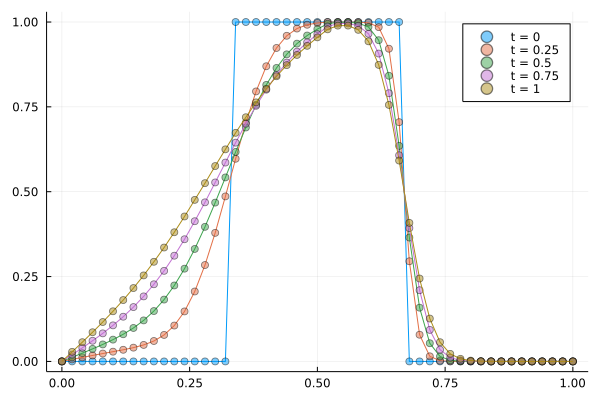

In [24]:
function ploterr(θ, u, tplot = LinRange(0.0, 1.0, 5); θ_ref = θ_ref)
    sol_ref = S(θ_ref, u[:, :, 1], tplot)
    sol = S(θ, u[:, :, 1], tplot)
    pl = plot()
    for (i, t) ∈ enumerate(tplot)
        plot!(pl, x, sol_ref[i]; color = i, label = nothing)
        scatter!(pl, x, sol[i]; label = "t = $t", color = i, markeralpha = 0.5)
    end
    pl
end
ploterr(θ_ref, u₃)

A callback function is called after every iteration of gradient descent, allowing us to
check the performance of our operator in real time during training. The return value
`false` simply stops the function from stopping the iterations. We can already check how
our initial guess for $\mathbf{A}$ performs.

In [25]:
function callback(θ, loss)
    println(loss)
    flush(stdout)
    false
end

callback (generic function with 1 method)

The intrusive training consists of improving the operator through gradient
descent applied to the loss function. The optimizer
[`ADAM`](https://arxiv.org/abs/1412.6980) performs a first order gradient
descent, but with some sophisiticated momentum terms exploiting the
stochasticity of the loss function. For larger problems we could could use a
subset of the different solutions $u$, time steps $t$ and spatial points $x$
at every evaluation of `loss`, but for now we will just use the entire
dataset.

https://diffeqflux.sciml.ai/dev/ControllingAdjoints/

In [26]:
loss = create_loss(train.u, tsnap, (1e-8, 1e-10))
result = DiffEqFlux.sciml_train(loss, θ, ADAM(0.01); cb = callback, maxiters = 1000)
θ_fit = result.u

34.81
73.41
34.27
44.03
49.46
37.43
29.09
30.16
33.62
33.98
31.26
27.8
25.82
25.67
26.03
25.75
24.83
23.84
23.15
22.67
22.12
21.51
21.04
20.81
20.67
20.48
20.14
19.66
19.15
18.73
18.5
18.44
18.43
18.28
17.93
17.49
17.17
17.02
16.97
16.9
16.75
16.52
16.27
16.07
15.93
15.82
15.71
15.58
15.43
15.28
15.14
15.02
14.9
14.78
14.66
14.56
14.45
14.35
14.24
14.12
14.01
13.91
13.83
13.74
13.65
13.54
13.45
13.36
13.27
13.19
13.11
13.02
12.94
12.86
12.78
12.7
12.63
12.55
12.48
12.4
12.33
12.26
12.19
12.12
12.05
11.98
11.91
11.85
11.78
11.72
11.65
11.59
11.53
11.47
11.41
11.35
11.29
11.23
11.17
11.11
11.06
11
10.95
10.89
10.84
10.79
10.73
10.68
10.63
10.58
10.53
10.48
10.43
10.38
10.33
10.28
10.23
10.19
10.14
10.09
10.05
10
9.958
9.913
9.869
9.826
9.782
9.74
9.697
9.655
9.613
9.572
9.531
9.491
9.451
9.411
9.371
9.332
9.293
9.255
9.217
9.179
9.142
9.104
9.068
9.031
8.995
8.959
8.923
8.888
8.853
8.818
8.784
8.75
8.716
8.682
8.649
8.616
8.583
8.55
8.518
8.486
8.454
8.422
8.391
8.36
8.329
8.298
8.268
8.

51×52 Matrix{Float64}:
 0   0          0          0        …   0          0          0
 0  -3.096     -1.047     -0.1851       0.02842    0.02842   -0.06197
 0  -0.9323    -2.811     -0.5071       0.003784   0.003784  -0.02824
 0   0.1008    -0.4438    -2.811        0.02384    0.02384    0.1472
 0   0.2702     0.1173    -0.2704      -0.01634   -0.01634    0.1467
 0   0.1556     0.1927     0.2566   …   0.02632    0.02632    0.1056
 0   0.2281     0.4225     0.3154      -0.03503   -0.03503    0.1318
 0   0.2538     0.1591     0.3182      -0.03176   -0.03176    0.1767
 0   0.07899    0.1517     0.299        0.01929    0.01929    0.1274
 0   0.09474    0.1706     0.1885      -0.009476  -0.009476   0.1712
 0   0.03087    0.1551     0.01539  …   0.02267    0.02267    0.2007
 0   0.03544    0.007923   0.1052      -0.001037  -0.001037   0.1821
 0  -0.1095     0.03974    0.0935      -0.008064  -0.008064   0.2029
 ⋮                                  ⋱              ⋮         
 0  -0.05004    0.182

In [27]:
A = θ[:, 1:end-1]
A_fit = θ_fit[:, 1:end-1]
A_ref = θ_ref[:, 1:end-1]

51×51 Matrix{Float64}:
  0    0    0    0    0    0    0    0  …   0     0     0     0     0    0
 25  -50   25    0    0    0    0    0      0     0     0     0     0    0
  0   25  -50   25    0    0    0    0      0     0     0     0     0    0
  0    0   25  -50   25    0    0    0      0     0     0     0     0    0
  0    0    0   25  -50   25    0    0      0     0     0     0     0    0
  0    0    0    0   25  -50   25    0  …   0     0     0     0     0    0
  0    0    0    0    0   25  -50   25      0     0     0     0     0    0
  0    0    0    0    0    0   25  -50      0     0     0     0     0    0
  0    0    0    0    0    0    0   25      0     0     0     0     0    0
  0    0    0    0    0    0    0    0      0     0     0     0     0    0
  0    0    0    0    0    0    0    0  …   0     0     0     0     0    0
  0    0    0    0    0    0    0    0      0     0     0     0     0    0
  0    0    0    0    0    0    0    0      0     0     0     0     0    0
  

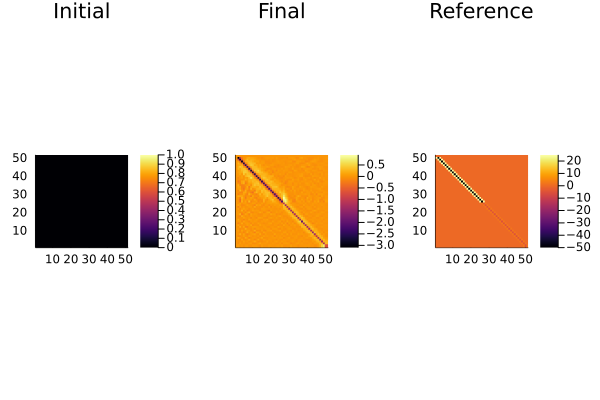

In [28]:
plot(
    plotmat(A; title = "Initial"),
    plotmat(A_fit; title = "Final"),
    plotmat(A_ref; title = "Reference");
    layout = (1, 3),
)

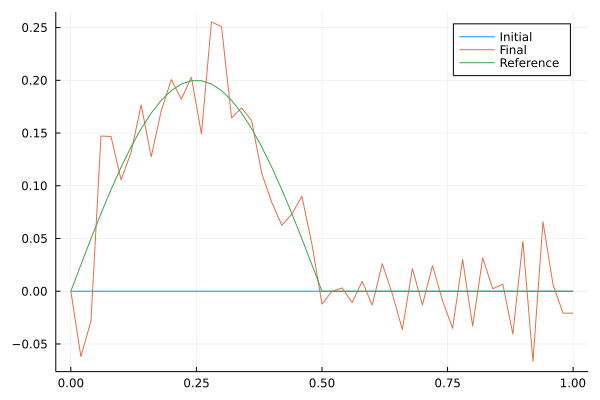

In [29]:
plot(x, θ[:, end]; label = "Initial")
plot!(x, θ_fit[:, end]; label = "Final")
plot!(x, θ_ref[:, end]; label = "Reference")

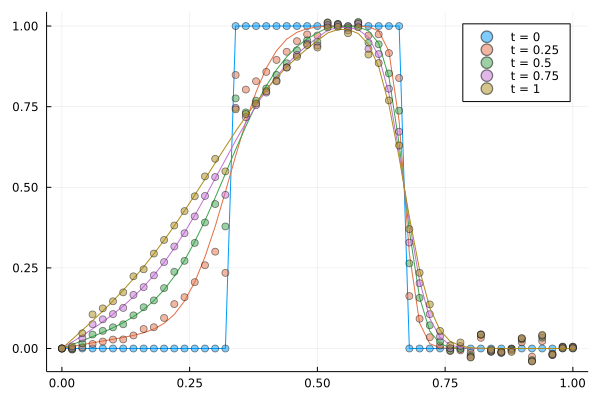

In [38]:
# ploterr(θ_fit, u₁)
# ploterr(θ_fit, u₂)
ploterr(θ_fit, u₃)
# ploterr(θ_fit, u₄)

Notice that at no point did we explicitly specify the gradient of `loss`, `S`
or even `f` with respect to the parameters `θ`. Yet still we performed a gradient
descent. Since the entire computational graph is composed of pure Julia code,
automatic differentiation engines, in this particular case
[Zygote](https://github.com/FluxML/Zygote.jl), can use the chain rule to
compute gradients. We may access this gradient explicitly. Let us compare the gradients:

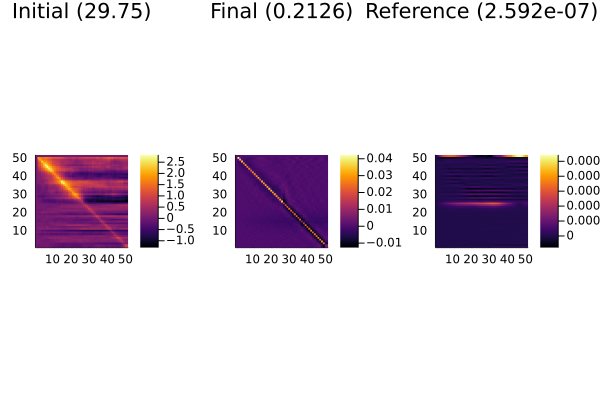

In [39]:
dLdθ = first(Zygote.gradient(loss, θ))
dLdθ_fit = first(Zygote.gradient(loss, θ_fit))
dLdθ_ref = first(Zygote.gradient(loss, θ_ref))

dLdA = dLdθ[:, 1:end-1]
dLdA_fit = dLdθ_fit[:, 1:end-1]
dLdA_ref = dLdθ_ref[:, 1:end-1]

dLds = dLdθ[:, end]
dLds_fit = dLdθ_fit[:, end]
dLds_ref = dLdθ_ref[:, end]

plot(
    plotmat(dLdA; title = "Initial ($(norm(dLdA)))"),
    plotmat(dLdA_fit; title = "Final ($(norm(dLdA_fit)))"),
    plotmat(dLdA_ref; title = "Reference ($(norm(dLdA_ref)))");
    layout = (1, 3),
)

# Proper orthogonal decomposition (POD)

Above we learned the discrete diffusion operator in the canonical basis of
$\mathbb{R}^N$. Another useful basis is obtained from a *proper orthogonal
decomposition* (POD). It is determined from snapshot data of the solution at
different time steps (`tsnap`) and possibly different initial conditions.
Truncating this basis at a level $P \ll N$ will yield *the* basis of size $P$
with the smallest error energy for the training data (among all possibile
bases spanning $P$-dimensional subspaces of $L^2(\Omega)$).

The POD basis is simply just a collection of left singular vectors of our snapshot matrix
$\mathbf{U}$. We will keep the $P$ first basis functions (they are the most important, as
`svd` orders them by decreasing singular value). The basis functions will be stored as
columns in the matrix $\mathbf{\Phi} \in \mathbb{R}^{N \times P}$.

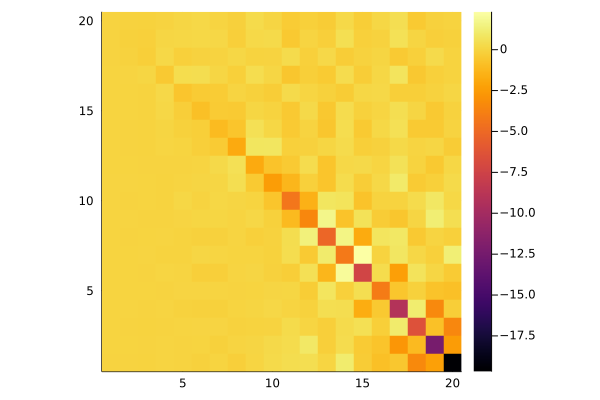

In [40]:
U = reshape(Array(train.u), N + 1, :)
P = 20
decomp = svd(U)
Φ = decomp.U[:, 1:P]
A_pod_ref = Φ' * A_ref * Φ
s_pod_ref = Φ's_ref
θ_pod_ref = [A_pod_ref s_pod_ref]
plotmat(A_pod_ref)

We may plot some POD modes.

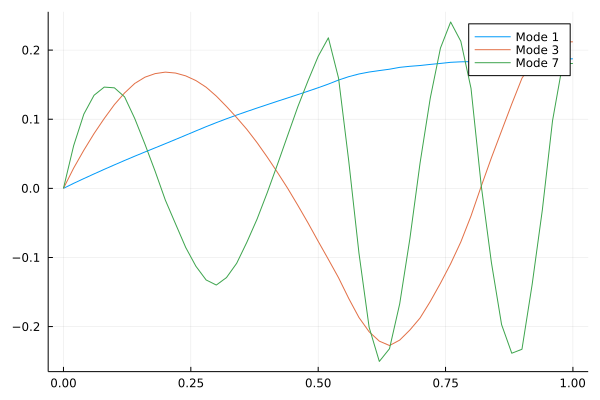

In [41]:
pl = plot();
for k ∈ [1, 3, 7]
    plot!(pl, x, Φ[:, k]; label = "Mode $k")
end
pl

We may check the orthogonality by computing the inner product between each basis function
pair.

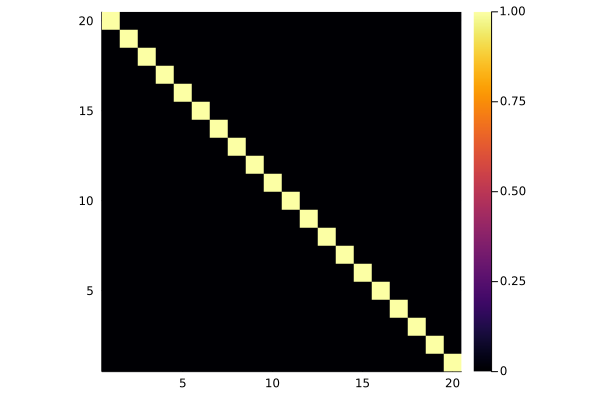

In [42]:
plotmat(Φ'Φ)

The matrix $\mathbf{Φ} \mathbf{Φ}^\mathsf{T}$ can be considered to be a so called
"autoencoder", with "encoder" $\mathbf{Φ}^\mathsf{T}$ and "decoder" $\mathbf{Φ}$. The
autoencoder should be closer to identity when keeping more modes, i.e. we may be tempted
to write something like $\mathbf{Φ} \mathbf{Φ}^\mathsf{T} \underset{P \to N}{\to}
\mathbf{I}$ (by abuse of mathematical notation).

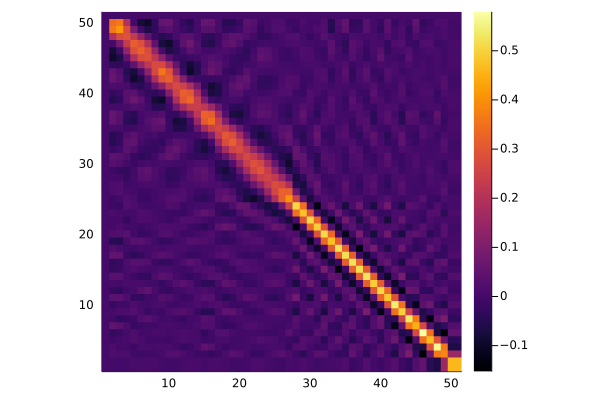

In [43]:
plotmat(Φ * Φ')

Projecting the full order model onto the POD basis yields the reduced order
model

$$\frac{\mathrm{d} \tilde{\mathbf{u}}}{\mathrm{d} t} = \tilde{\mathbf{A}}
\tilde{\mathbf{u}} + \tilde{\mathbf{s}},$$

where $\tilde{\mathbf{u}}$ are the coordinates of the ROM solution in the POD
basis, $\tilde{\mathbf{A}} = \mathbf{\Phi}^\mathsf{T} \mathbf{A}
\mathbf{\Phi} \in \mathbb{R}^{P \times P}$ is the reduced order operator, and
$\tilde{\mathbf{s}} = \mathbf{\Phi}^\mathsf{T} \mathbf{s}. Later, we will try
to infer this operator directly from data. Note that the ROM solution is
given by $\mathbf{u}_\text{ROM} = \mathbf{\Phi} \tilde{\mathbf{u}}$.

Note also that the FOM and ROM have the same form, just different sizes (and
"tilde"s appearing everywhere). The ROM solution may thus simply be computed
by

$$\mathbf{u}_\text{ROM}(t) = \mathbf{\Phi} \mathbf{S}(\tilde{\mathbf{\theta}},
\mathbf{\Phi}^\mathsf{T} \mathbf{u}_0, t).$$

Let us compare the solution of the ROM and FOM:

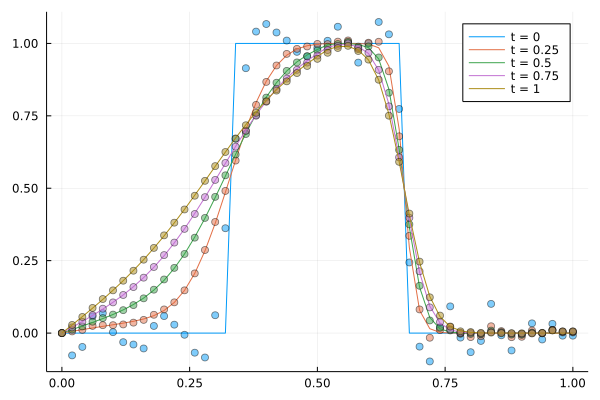

In [45]:
# u₀ = u₁
# u₀ = u₂
u₀ = u₃
# u₀ = u₄
tplot = LinRange(0.0, 1.0, 5)
sol = S(θ_ref, u₀, tplot)
sol_pod = S(θ_pod_ref, Φ' * u₀, tplot)
p = plot();
for (i, t) ∈ enumerate(tplot)
    plot!(p, x, sol[i]; label = "t = $t", color = i) # FOM
    scatter!(p, x, Φ * sol_pod[:, i]; label = nothing, markeralpha = 0.5, color = i) # ROM
end
p

## Learning the operator in the POD basis

Similarly to the full order model case, we may fit the POD operator
$\tilde{A}$ using intrusive and non-intrusive approaches.

First we need to create snapshot tensors of the POD solutions/observations:

In [46]:
u_pod = zeros(P, nsample, length(tsnap))
for i ∈ eachindex(tsnap)
    u_pod[:, :, i] = Φ' * train.u[:, :, i]
end

We may also reuse the loss function and ODE solver from the full order case
(only the sizes change).

In [47]:
loss_pod = create_loss(u_pod, tsnap)
θ_pod = zeros(P, P+1)
A_pod = θ_pod[:, 1:end-1]
s_pod = θ_pod[:, end]
result = DiffEqFlux.sciml_train(
    loss_pod,
    θ_pod,
    ADAM(0.01);
    cb = callback,
    maxiters = 1000,
)
θ_pod_fit = result.u
A_pod_fit = θ_pod_fit[:, 1:end-1]
s_pod_fit = θ_pod_fit[:, end]

64.89
60.77
56.72
53.75
51.26
48.73
46.37
44.44
42.87
41.42
39.97
38.61
37.41
36.36
35.38
34.44
33.55
32.74
31.99
31.27
30.59
29.95
29.36
28.79
28.25
27.72
27.21
26.72
26.26
25.8
25.35
24.92
24.51
24.11
23.73
23.34
22.97
22.62
22.28
21.95
21.63
21.32
21.01
20.71
20.43
20.15
19.87
19.61
19.35
19.09
18.84
18.6
18.37
18.14
17.91
17.7
17.48
17.27
17.07
16.87
16.67
16.48
16.3
16.12
15.94
15.76
15.59
15.43
15.26
15.1
14.94
14.79
14.64
14.49
14.34
14.2
14.06
13.92
13.79
13.66
13.53
13.4
13.27
13.15
13.03
12.91
12.79
12.67
12.56
12.45
12.34
12.23
12.13
12.02
11.92
11.82
11.72
11.62
11.52
11.43
11.33
11.24
11.15
11.06
10.97
10.88
10.8
10.71
10.63
10.55
10.47
10.39
10.31
10.23
10.16
10.08
10.01
9.931
9.859
9.787
9.717
9.647
9.578
9.51
9.443
9.377
9.312
9.247
9.183
9.12
9.058
8.997
8.936
8.876
8.817
8.759
8.701
8.644
8.588
8.532
8.477
8.422
8.369
8.316
8.263
8.211
8.16
8.109
8.059
8.009
7.96
7.911
7.863
7.816
7.769
7.722
7.676
7.631
7.586
7.542
7.497
7.454
7.411
7.368
7.326
7.284
7.243
7.202
7.16

20-element Vector{Float64}:
  0.2444
  0.4951
  0.3794
 -0.2068
  0.01358
 -0.0469
 -0.06196
 -0.03645
  0.0006204
 -0.01704
 -0.0443
 -0.004895
 -0.0007172
  0.01474
 -0.09075
 -0.01044
 -0.04437
 -0.03323
 -0.05351
 -0.03424

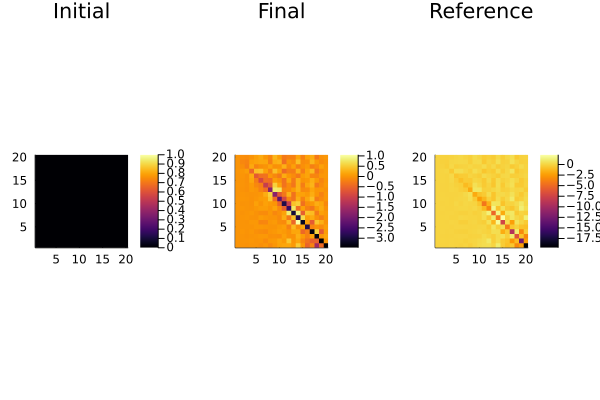

In [48]:
plot(
    plotmat(A_pod; title = "Initial"),
    plotmat(A_pod_fit; title = "Final"),
    plotmat(A_pod_ref; title = "Reference");
    layout = (1, 3),
)

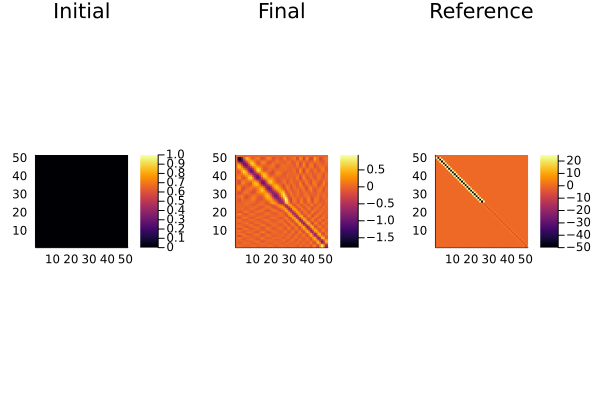

In [49]:
plot(
    plotmat(Φ * A_pod * Φ'; title = "Initial"),
    plotmat(Φ * A_pod_fit * Φ'; title = "Final"),
    # plotmat(Φ * A_pod_ref * Φ'; title = "Reference");
    plotmat(A_ref; title = "Reference");
    layout = (1, 3),
)

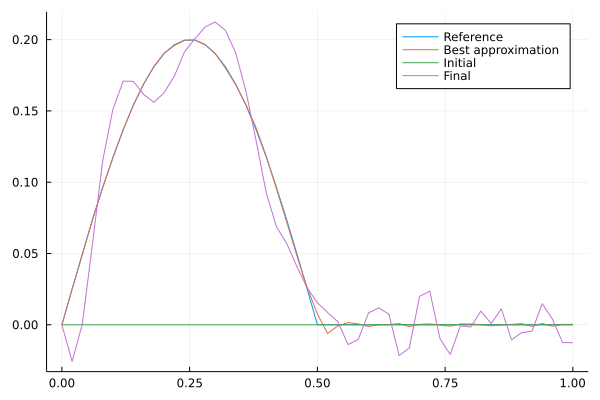

In [51]:
pl = plot(x, s_ref; label = "Reference")
plot!(pl, x, Φ * s_pod_ref; label = "Best approximation")
plot!(pl, x, Φ * s_pod; label = "Initial")
plot!(pl, x, Φ * s_pod_fit; label = "Final")
pl

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*